In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ndcg_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import ShuffleSplit  

from scipy import stats

import xgboost as xgb

from tqdm import tqdm

In [2]:
df=pd.read_csv(r'C:\Users\kogla\OneDrive\SWE599-Flight-Ticket-Price-Estimation-Project\merged.csv').drop("Unnamed: 0", axis=1)
df.head()

,company,departure_airport,arrival_airport,departure_time,arrival_time,departure_date,price_try,departure_week_day,checked_week_day,departure_day,departure_month,remaining_day_to_flight,arrival_city,departure_airport_name,departure_hour,part_of_day,is_weekend,part_of_month,duration(min)
0,AnadoluJet,SAW,ADB,07:30:00,08:40:00,2022-11-14,506.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,7,Early Morning,Weekday,Middle,70
1,AnadoluJet,SAW,ADB,09:20:00,10:30:00,2022-11-14,506.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,9,Morning,Weekday,Middle,70
2,AnadoluJet,SAW,ADB,20:55:00,22:05:00,2022-11-14,506.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,20,Evening,Weekday,Middle,70
3,Pegasus,SAW,ADB,23:35:00,00:45:00,2022-11-14,539.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,23,Night,Weekday,Middle,70
4,Pegasus,SAW,ADB,09:10:00,10:20:00,2022-11-14,542.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,9,Morning,Weekday,Middle,70


In [3]:
df_copy = df.copy()

In [4]:
# departure_date, departure_day, departure_month info are held as is_weekend, departure_week_day and part_of_month. 
# departure_airport and departure_airport_name columns include same info. 
# arrival_airport and arrival_city columns include same info. Drop arrival_airport.
# departure_time and departure_hour info are  held as part_of_day.
# arrival_time info is not neccessary
# checked_week_day is held as remaining_day_to_flight

df_copy=df_copy.drop(['departure_date', 'departure_day', 'departure_month', 'departure_airport', 'arrival_airport','departure_time', 'departure_hour', 'arrival_time', 'checked_week_day',   ], axis=1)

In [5]:
# asign types to columns
df_copy['company'] = df_copy.company.astype('category')
df_copy['departure_airport_name'] = df_copy.departure_airport_name.astype('category')
df_copy['arrival_city'] = df_copy.arrival_city.astype('category')
df_copy['part_of_day'] = df_copy.part_of_day.astype('category')
df_copy['departure_week_day'] = df_copy.departure_week_day.astype('category')
df_copy['part_of_month'] = df_copy.part_of_month.astype('category')
df_copy['is_weekend'] = df_copy.is_weekend.astype('category')
df_copy["price_try"] = df_copy["price_try"].astype("int64")

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129513 entries, 0 to 129512
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   company                  129513 non-null  category
 1   price_try                129513 non-null  int64   
 2   departure_week_day       129513 non-null  category
 3   remaining_day_to_flight  129513 non-null  int64   
 4   arrival_city             129513 non-null  category
 5   departure_airport_name   129513 non-null  category
 6   part_of_day              129513 non-null  category
 7   is_weekend               129513 non-null  category
 8   part_of_month            129513 non-null  category
 9   duration(min)            129513 non-null  int64   
dtypes: category(7), int64(3)
memory usage: 3.8 MB


In [6]:
# change column order to increase readibility
df_copy = df_copy[['company', 'departure_airport_name', 'arrival_city','part_of_day', 'departure_week_day', 
                   'part_of_month','is_weekend', 'duration(min)','price_try', 'remaining_day_to_flight' ]]

In [7]:
# get list of categorical columns except arrival_city
categorical_cols = df_copy.select_dtypes(include=['category']).columns.to_list()
categorical_cols.remove("arrival_city")
categorical_cols

['company',
 'departure_airport_name',
 'part_of_day',
 'departure_week_day',
 'part_of_month',
 'is_weekend']

In [8]:
# convert categorical columns to numbers except arrival_city
dummies_data = pd.get_dummies(df_copy[categorical_cols])
df_copy = pd.concat([df_copy.drop(categorical_cols, axis=1), dummies_data], axis=1)

In [9]:
# rename columns
df_copy.rename(columns = {'company_Türk Hava Yolları':'TurkishAirlines', 
                          'company_AnadoluJet':'AnadoluJet',
                          'company_Pegasus': 'Pegasus',
                          'departure_airport_name_Istanbul Airport': 'Istanbul_Airport',
                          'departure_airport_name_Sabiha Gökçen Airport': 'Sabiha_Gokcen',
                          'part_of_day_Early Morning': 'Early_Morning_Flights',
                          'part_of_day_Morning': 'Morning_Flights',
                          'part_of_day_Noon': 'Noon_Flights',
                          'part_of_day_Evening': 'Evening_Flights',
                          'part_of_day_Night': 'Night_Flights',
                          'part_of_day_Late Night': 'Late_Night_Flights',
                          'departure_week_day_Monday': 'Monday_Flights',
                          'departure_week_day_Tuesday': 'Tuesday_Flights',
                          'departure_week_day_Wednesday': 'Wednesday_Flights',
                          'departure_week_day_Thursday': 'Thursday_Flights',
                          'departure_week_day_Friday': 'Friday_Flights',
                          'departure_week_day_Saturday': 'Saturday_Flights',
                          'departure_week_day_Sunday': 'Sunday_Flights',
                          'part_of_month_Beginning': 'Beginning_of_Month',
                          'part_of_month_Middle': 'Middle_of_Month',
                          'part_of_month_End': 'End_of_Month',
                          'is_weekend_Weekday': 'Weekday_Flight',
                          'is_weekend_Weekend': 'Weekend_Flights'}, inplace = True)


In [10]:
# create rank column for price lower price has 1 rank, higher price has 5 rank

cities=['Izmir','Ankara','Antalya','Adana','Bodrum Milas','Dalaman','Trabzon','Gaziantep','Diyarbakir','Hatay','Kars', 'Erzurum', 'Mardin']

df_rank = pd.DataFrame()

for city in cities:
    group=df_copy[df_copy['arrival_city']==city]
    ranges=group['price_try'].dropna().quantile([0.0, .10, .02, .03, .40, .05, .60, .07, .80, .09, 1]).tolist()
    conditions = [
    (group['price_try'] < ranges[1]),
    (group['price_try'] >= ranges[1]) & (group['price_try'] < ranges[2]),
    (group['price_try'] >= ranges[2]) & (group['price_try'] < ranges[3]),
    (group['price_try'] >= ranges[3]) & (group['price_try'] < ranges[4]),
    (group['price_try'] >= ranges[4]) & (group['price_try'] < ranges[5]),
    (group['price_try'] >= ranges[5]) & (group['price_try'] < ranges[6]),
    (group['price_try'] >= ranges[6]) & (group['price_try'] < ranges[7]),
    (group['price_try'] >= ranges[7]) & (group['price_try'] < ranges[8]),
    (group['price_try'] >= ranges[8]) & (group['price_try'] < ranges[9]),
    (group['price_try'] >= ranges[9])
    ]
    values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    group['Rank'] = np.select(conditions, values)
    group.append(df_rank, ignore_index=True)
    df_rank = pd.concat([df_rank, group], ignore_index=True, sort=False)


C:\Users\kogla\AppData\Local\Temp\ipykernel_9792\3914392864.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['Rank'] = np.select(conditions, values)
C:\Users\kogla\AppData\Local\Temp\ipykernel_9792\3914392864.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group.append(df_rank, ignore_index=True)
C:\Users\kogla\AppData\Local\Temp\ipykernel_9792\3914392864.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [11]:
df_rank=df_rank.drop("price_try",axis=1)

In [12]:
# split dataset
shufflesplit = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0) 
for train_index, test_index in shufflesplit.split(df_rank):
    train_data, test_data = df_rank.iloc[train_index], df_rank.iloc[test_index]

In [13]:
X_train = train_data.loc[:, ~train_data.columns.isin(['arrival_city','Rank'])]
y_train = train_data.loc[:, train_data.columns.isin(['Rank'])]

train_groups = train_data.groupby('arrival_city').size().to_frame('size')['size'].to_numpy()

X_test = test_data.loc[:, ~test_data.columns.isin(['Rank'])]
y_test = test_data.loc[:, test_data.columns.isin(['Rank'])]

test_groups = test_data.groupby('arrival_city').size().to_frame('size')['size'].to_numpy()

In [14]:
model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.01,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75,
    n_jobs=-1
    )

model.fit(X_train, y_train, group=train_groups,verbose =True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, early_stopping_rounds=None,
          enable_categorical=False, eta=0.05, eval_metric=None,
          feature_types=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
          importance_type=None, interaction_constraints='', learning_rate=0.01,
          max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
          max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=110, n_jobs=-1,
          num_parallel_tree=1, predictor='auto', ...)

In [15]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['arrival_city'])])
  
predictions = (X_test.groupby('arrival_city')
               .apply(lambda x: predict(model, x)))

In [16]:
predictions

arrival_city
Adana           [-0.11709097, 1.1395819, 1.0526363, 0.38866544...
Ankara          [0.92612547, 0.89524597, -0.12034319, 0.976638...
Antalya         [0.8260321, -0.05909036, 0.44269678, 0.9340899...
Bodrum Milas    [1.0146289, 1.0164938, -0.029647062, 0.0887942...
Dalaman         [0.685314, 1.0744288, 0.34581766, -0.12966713,...
Diyarbakir      [0.31774002, 0.020756977, -0.09007273, 1.31948...
Erzurum         [1.0349948, -0.11033684, 1.1388913, 0.06942023...
Gaziantep       [0.7299784, 0.5338904, 0.22510853, -0.08266398...
Hatay           [0.48270857, 1.0229379, -0.112122156, 1.008464...
Izmir           [0.011397993, 0.06948578, 0.18973659, 0.029395...
Kars            [1.2285287, -0.028343996, 0.068277225, -0.0921...
Mardin          [0.25274906, 1.1636025, 1.1623865, 1.0158474, ...
Trabzon         [-0.08911417, 0.9902932, -0.09238201, -0.14710...
dtype: object

In [17]:
predictions.apply(lambda pred: np.argsort(pred)[:-5])

arrival_city
Adana           [2181, 1590, 2055, 1824, 1072, 696, 847, 1721,...
Ankara          [1022, 1340, 1023, 3646, 2989, 7, 77, 3775, 15...
Antalya         [324, 3139, 1015, 2614, 3253, 1119, 3324, 2986...
Bodrum Milas    [1353, 326, 961, 251, 100, 1159, 451, 978, 107...
Dalaman         [416, 650, 130, 31, 161, 536, 832, 418, 182, 5...
Diyarbakir      [447, 246, 1135, 34, 1098, 532, 1074, 1086, 92...
Erzurum         [605, 483, 266, 230, 686, 204, 495, 381, 417, ...
Gaziantep       [877, 972, 1884, 856, 546, 1675, 1747, 1077, 5...
Hatay           [337, 504, 495, 989, 512, 647, 715, 527, 157, ...
Izmir           [3101, 2234, 462, 2230, 4240, 1375, 1292, 1520...
Kars            [317, 71, 223, 295, 456, 204, 357, 253, 227, 4...
Mardin          [224, 4, 241, 448, 264, 427, 379, 399, 160, 42...
Trabzon         [340, 424, 1190, 1278, 2160, 1418, 1865, 2156,...
dtype: object

## ADANA

In [26]:
test_data[test_data["arrival_city"]=="Adana"].iloc[[2055]][["arrival_city","Rank"]]

,arrival_city,Rank
66385,Adana,1


In [29]:
test_data[test_data["arrival_city"]=="Adana"].iloc[[1072]][["arrival_city","Rank"]]

,arrival_city,Rank
64522,Adana,4


## ANKARA

In [35]:
test_data[test_data["arrival_city"]=="Ankara"].iloc[[1022]][["arrival_city","Rank"]]

,arrival_city,Rank
27360,Ankara,1


In [117]:
test_data[test_data["arrival_city"]=="Ankara"].iloc[[1340]][["arrival_city","Rank"]]

,arrival_city,Rank
21978,Ankara,4


## ANTALYA

In [44]:
test_data[test_data["arrival_city"]=="Antalya"].iloc[[2986]][["arrival_city","Rank"]]

,arrival_city,Rank
45814,Antalya,1


## BODRUM MİLAS

In [45]:
test_data[test_data["arrival_city"]=="Bodrum Milas"].iloc[[1353]][["arrival_city","Rank"]]

,arrival_city,Rank
75998,Bodrum Milas,1


In [50]:
test_data[test_data["arrival_city"]=="Bodrum Milas"].iloc[[1159]][["arrival_city","Rank"]]

,arrival_city,Rank
77741,Bodrum Milas,4


## DALAMAN

In [51]:
test_data[test_data["arrival_city"]=="Dalaman"].iloc[[416]][["arrival_city","Rank"]]

,arrival_city,Rank
84510,Dalaman,1


In [58]:
test_data[test_data["arrival_city"]=="Dalaman"].iloc[[5]][["arrival_city","Rank"]]

,arrival_city,Rank
86340,Dalaman,6


## DİYARBAKIR

In [59]:
test_data[test_data["arrival_city"]=="Diyarbakir"].iloc[[447]][["arrival_city","Rank"]]

,arrival_city,Rank
111347,Diyarbakir,1


In [62]:
test_data[test_data["arrival_city"]=="Diyarbakir"].iloc[[92]][["arrival_city","Rank"]]

,arrival_city,Rank
113194,Diyarbakir,4


## ERZURUM

In [69]:
test_data[test_data["arrival_city"]=="Erzurum"].iloc[[417]][["arrival_city","Rank"]]

,arrival_city,Rank
123424,Erzurum,1


## GAZİANTEP

In [68]:
test_data[test_data["arrival_city"]=="Gaziantep"].iloc[[1077]][["arrival_city","Rank"]]

,arrival_city,Rank
102928,Gaziantep,1


## HATAY

In [73]:
test_data[test_data["arrival_city"]=="Hatay"].iloc[[337]][["arrival_city","Rank"]]

,arrival_city,Rank
116816,Hatay,1


In [72]:
test_data[test_data["arrival_city"]=="Hatay"].iloc[[157]][["arrival_city","Rank"]]

,arrival_city,Rank
115232,Hatay,4


## İZMİR

In [76]:
test_data[test_data["arrival_city"]=="Izmir"].iloc[[3101]][["arrival_city","Rank"]]

,arrival_city,Rank
8245,Izmir,1


In [77]:
test_data[test_data["arrival_city"]=="Izmir"].iloc[[1520]][["arrival_city","Rank"]]

,arrival_city,Rank
7468,Izmir,4


## KARS

In [78]:
test_data[test_data["arrival_city"]=="Kars"].iloc[[227]][["arrival_city","Rank"]]

,arrival_city,Rank
120519,Kars,1


## MARDİN

In [87]:
test_data[test_data["arrival_city"]=="Mardin"].iloc[[224]][["arrival_city","Rank"]]

,arrival_city,Rank
127590,Mardin,4


In [88]:
test_data[test_data["arrival_city"]=="Mardin"].iloc[[4]][["arrival_city","Rank"]]

,arrival_city,Rank
128075,Mardin,1


In [89]:
test_data[test_data["arrival_city"]=="Mardin"].iloc[[379]][["arrival_city","Rank"]]

,arrival_city,Rank
127909,Mardin,4


## TRABZON

In [90]:
test_data[test_data["arrival_city"]=="Trabzon"].iloc[[340]][["arrival_city","Rank"]]

,arrival_city,Rank
92408,Trabzon,1


In [96]:
test_data[test_data["arrival_city"]=="Trabzon"].iloc[[2156]][["arrival_city","Rank"]]

,arrival_city,Rank
91387,Trabzon,4


In [111]:
## arrival city distribution among dataset
group = df_copy.groupby('arrival_city').count()
group["count"]=group["price_try"]
group["count"]

arrival_city
Adana           14619
Ankara          19248
Antalya         20047
Bodrum Milas     6672
Dalaman          5557
Diyarbakir       5789
Erzurum          4397
Gaziantep        9950
Hatay            5513
Izmir           21744
Kars             2394
Mardin           2381
Trabzon         11202
Name: count, dtype: int64

## FEATURE IMPORTANCE

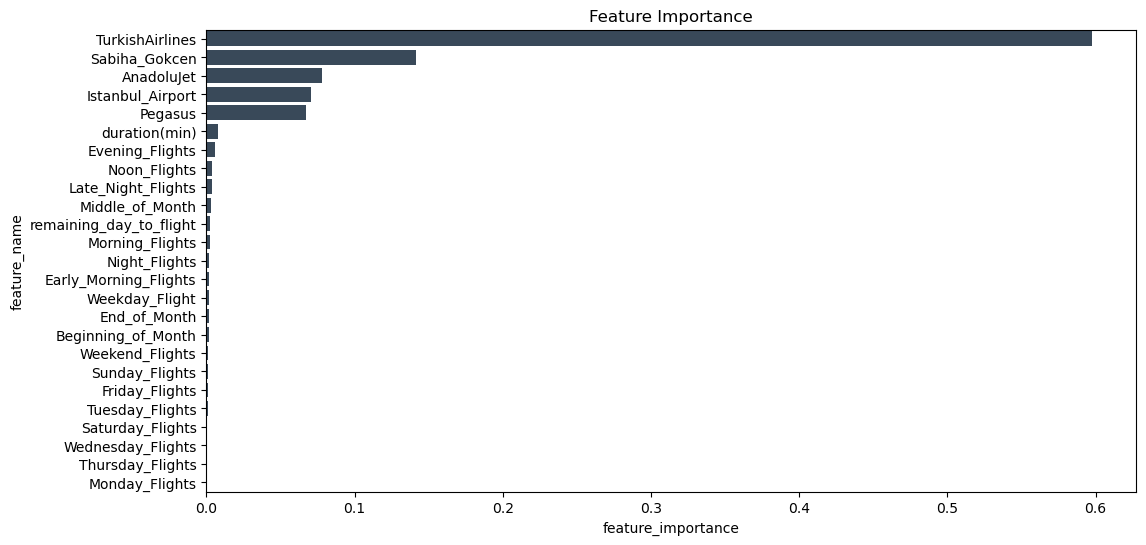

In [99]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt, color="#34495E")
plt.title('Feature Importance')
plt.show()